<a href="https://colab.research.google.com/github/IISC-GROUP-5/Jupyter_Notebooks/blob/Pratima/LR_model_Combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ad click Prediction and Gender Classification with behavioral data

In [36]:
import pip
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import io
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score, confusion_matrix,f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

import pickle
import os

warnings.filterwarnings("ignore")

# Data Preprocessing

In [37]:
def preprocess_data(data):
    """
    Cleans and preprocesses the given DataFrame.

    Args:
        df: The pandas DataFrame to be cleaned and preprocessed.

    Returns:
        The cleaned and preprocessed DataFrame.

    """
    df = pd.read_csv(data)
    # Replace spaces in column names with underscores
    df.columns = df.columns.str.replace(' ', '_')

    # Handle missing values
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if pd.api.types.is_numeric_dtype(df[col]):
                # For numeric columns, fill missing values with median
                df[col].fillna(df[col].median(), inplace=True)
            else:
                # For categorical columns, fill missing values with the most frequent value
                df[col].fillna(df[col].mode()[0], inplace=True)

    # Round 'Area Income' to 2 decimal places
    df['Area_Income'] = df['Area_Income'].round(2)

    #label_encoding_mapping = {'Female': 1, 'Male': 0}
    #df['Gender'] = df['Gender'].map(label_encoding_mapping)

    return df


# Data Visualization

In [38]:
def visualize_correlation_matrix(cl_df, model_name):
  """
  Visualizes the correlation matrix of a DataFrame.

  Args:
    df: The pandas DataFrame to analyze.

  Returns:
    None
  """
  num_df = cl_df.select_dtypes(include=np.number)
  corr_matrix = num_df.corr()

  # Mask the upper triangle to avoid redundancy
  mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

  # Create a heatmap
  sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm')
  plt.title('Correlation Matrix')
  plt.savefig(model_name+'_CM'+'.jpg', dpi = 300)
  plt.show()


In [39]:
def visualize_data(cl_df,model_name):
  """
  Visualizes various aspects of the given DataFrame.

  Args:
    df: The pandas DataFrame to visualize.
  """

  # Histogram to visualize numerical data distribution
  sns.histplot(cl_df['Daily_Time_Spent_on_Site'], kde=True)
  plt.title('Distribution of people spending time on site')
  plt.xlabel('Daily Time Spent_on_Site')
  plt.ylabel('No. of People')
  plt.savefig(model_name+'_Histogram'+'.jpg', dpi = 300)
  plt.show()

  # Scatter plot to visualize relationship between Age & Area Income
  sns.scatterplot(x='Age', y= 'Area_Income', data=cl_df)
  plt.title('Scatter Plot: Age vs Area Income')
  plt.savefig(model_name+'_Scatterplot1'+'.jpg', dpi = 300)
  plt.show()

  #Scatter plot to visualize relationship between Age vs Daily Internet Usage
  sns.scatterplot(x='Age', y='Daily_Internet_Usage', data=cl_df)
  plt.title('Scatter Plot: Age vs Daily Internet Usage')
  plt.savefig(model_name+'_Scatterplot2'+'.jpg', dpi = 300)
  plt.show()


  # Pair plot to visualize relationships between multiple numerical columns
  sns.pairplot(cl_df, hue= 'Clicked_on_Ad')
  plt.savefig(model_name+'_Pairplot'+'.jpg', dpi = 300)
  plt.show()



In [40]:
def analyze_categorical_features(cl_df, feature_list,model_name,target_name):
  """
  Analyzes the distribution of categorical features in a DataFrame.

  Args:
    df: The pandas DataFrame to analyze.
    feature_list: A list of categorical feature names.

  Returns:
    None
  """

  for feature in feature_list:
    value_counts = cl_df[feature].value_counts()
    print(f"Value counts for {feature}:\n{value_counts}\n")

    # Visualize the distribution
    sns.countplot(x=feature, data=cl_df)
    plt.title(f'Distribution of {feature}')
    plt.savefig(model_name+target_name+'_Categorical Features'+'.jpg', dpi = 300)
    plt.show()


# Data Modelling

In [41]:
def label_encode_categorical_column(cl_df, column_name):
  """
  Encodes a categorical column in a DataFrame using LabelEncoder.

  Args:
    df: The pandas DataFrame.
    column_name: The name of the categorical column to encode.

  Returns:
    The DataFrame with the encoded column.
  """

  label_encoder = LabelEncoder()
  cl_df[column_name] = label_encoder.fit_transform(cl_df[column_name])
  return cl_df


# Logistic Regression

In [42]:
def split_data(X , y ,  test_size=0.2, random_state=42):
    """
    Splits the data into training and testing sets.

    Args:
        X: The feature matrix.
        y: The target variable.
        test_size: The proportion of the dataset to include in the test set.
        shuffle: Whether to shuffle the data before splitting.

    Returns:
        A tuple of four arrays: x_train, x_test, y_train, y_test.
    """

    X_train , X_test , y_train , y_test = train_test_split( X , y , test_size=test_size, random_state=random_state)
    return X_train , X_test , y_train , y_test


In [43]:
def logistic_regression_model(cl_df, X , y, X_train, X_test, y_train , y_test,):
  """
  Trains a Logistic Regression model on the given DataFrame, evaluates its performance, and performs cross-validation.

  Args:
    df: The pandas DataFrame containing the data.
    target_col: The name of the target column (e.g., 'Gender').
    feature_cols: A list of column names to be used as features.

  Returns:
    None
  """
  label_encode_categorical_column(cl_df, 'Gender')

  # Create and train the model
  model = LogisticRegression(solver='lbfgs')
  model.fit(X_train, y_train)

  # Make predictions on the test set
  y_pred = model.predict(X_test)

  # Evaluate the model
  print('Target Variable:', y)
  print('Accuracy Score:', accuracy_score(y_test, y_pred))
  print('Precision Score:', precision_score(y_test, y_pred))
  print('Recall Score:', recall_score(y_test, y_pred))
  print('F1 Score:', f1_score(y_test, y_pred))
  print('Classification Report:\n', classification_report(y_test, y_pred))
  print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

  # Perform cross-validation
  accuracies = cross_val_score(estimator=model, X=X_test, y=y_test, cv=10)
  print(f"Mean Accuracy Score: {accuracies.mean()}")
  print(f"Standard Deviation of Accuracy Score: {accuracies.std()}")

  return model , y_pred


In [44]:
def tune_logistic_regression(cl_df,X, y,X_train , X_test, y_train, y_test, param_grid=None):
    """
    Tunes hyperparameters for a logistic regression model using GridSearchCV.

    Args:
        X: Feature matrix.
        y: Target variable.
        param_grid: Dictionary of hyperparameters to tune. If None, a default grid is used.

    Returns:
        The best model after hyperparameter tuning.
    """

    if param_grid is None:
        param_grid = {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model,_ = logistic_regression_model(cl_df, X , y , X_train ,X_test, y_train, y_test)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    print("Best parameters:", grid_search.best_params_)
    print("Best accuracy:", grid_search.best_score_)

    return grid_search.best_estimator_

In [45]:
def plot_confusion_matrix(y_test, y_pred, class_names,target_name):

  """
  Plots a confusion matrix to visualize classification performance.

  Args:
    y_test: True labels of the test data.
    y_pred: Predicted labels from the model.
    class_names: List of class names for labeling the confusion matrix.

  Returns:
    None
  """
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.savefig(target_name+'_Confusion Matrix'+'.jpg', dpi = 300)
  plt.show()

In [46]:
def plot_roc_curve(y_test, y_pred_prob, model_name,target_name):
  """
  Plots the Receiver Operating Characteristic (ROC) curve and calculates the AUC.

  Args:
    y_true: True labels of the test data.
    y_pred_prob: Predicted probabilities of the positive class.

  Returns:
    None
  """

  fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
  auc = roc_auc_score(y_test, y_pred_prob)

  plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  plt.savefig(model_name+target_name+'_ROC_Curve'+'.jpg', dpi = 300)
  plt.show()

  return fpr, tpr, auc


In [47]:
def compare_metrics(model1, model2, X_test, y_test):
    """
    Compares the performance metrics of two models before and after hyperparameter tuning.

    Args:
        model_before_tuning: The model before hyperparameter tuning.
        model_after_tuning: The model after hyperparameter tuning.
        X_test: The test feature data.
        y_test: The test target data.

    Returns:
        None
    """
    if model2 == None:
      y_pred = model1.predict(X_test)

      print("Accuracy:", accuracy_score(y_test, y_pred))
      print("Precision:", precision_score(y_test, y_pred))
      print("Recall:", recall_score(y_test, y_pred))
      print("F1-score:", f1_score(y_test, y_pred))

    else:

      y_pred_before = model1.predict(X_test)
      y_pred_after = model2.predict(X_test)

      print("Metrics Before Hyperparameter Tuning:")
      print("Accuracy:", accuracy_score(y_test, y_pred_before))
      print("Precision:", precision_score(y_test, y_pred_before))
      print("Recall:", recall_score(y_test, y_pred_before))
      print("F1-score:", f1_score(y_test, y_pred_before))

      print("\nMetrics After Hyperparameter Tuning:")
      print("Accuracy:", accuracy_score(y_test, y_pred_after))
      print("Precision:", precision_score(y_test, y_pred_after))
      print("Recall:", recall_score(y_test, y_pred_after))
      print("F1-score:", f1_score(y_test, y_pred_after))


In [48]:
def save_metrics_to_file(model_name, target_name1,y_test, y_pred_prob, model1, model2):
  """
  Saves the evaluation metrics to a text file.

  Args:
    metrics: A dictionary containing evaluation metrics.
    model_name: The name of the model.
    target_name: The name of the target variable.

  Returns:
    None

  """
  if model2 == None:
    y_pred = model1.predict(X_test)
    auc_score = roc_auc_score(y_test, y_pred_prob) # Calculate AUC and store it
    metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"]
    metrics_values = [accuracy_score(y_test,y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred), auc_score]
    metrics = dict(zip(metrics, metrics_values))
    with open(f"{model_name}_{target_name1}_metrics.txt", "w") as file:
      file.write(f"Metrics:\n")
      for key, value in metrics.items():
        file.write(f"{key}: {value}\n")
      file.write(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")
      accuracies = cross_val_score(estimator=model1, X=X_test, y=y_test, cv=10)
      file.write(f"Mean Accuracy Score: \n{accuracies.mean()}\n")
      file.write(f"Standard Deviation of Accuracy Score:\n{accuracies.std()}\n")
    print(f"Metrics saved to {model_name}_{target_name1}_metrics.txt")

  else:
    y_pred_before = model1.predict(X_test)
    y_pred_after = model2.predict(X_test)
    auc_score = roc_auc_score(y_test, y_pred_prob) #Calculate AUC
    metrics1 = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"]
    metrics2 = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"]
    metrics_values1 = [accuracy_score(y_test, y_pred_before), precision_score(y_test, y_pred_before), recall_score(y_test, y_pred_before), f1_score(y_test, y_pred_before), auc_score]
    metrics_values2 = [accuracy_score(y_test, y_pred_after), precision_score(y_test, y_pred_after), recall_score(y_test, y_pred_after), f1_score(y_test, y_pred_after), auc_score]
    metrics1 = dict(zip(metrics1, metrics_values1))
    metrics2 = dict(zip(metrics2, metrics_values2))
    with open(f"{model_name}_{target_name2}_metrics.txt", "w") as file:
      file.write(f"Metrics Before Hyperparameter Tuning:\n")
      for key, value in metrics1.items():
        file.write(f"{key}: {value}\n")
      file.write(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_before)}\n")
      accuracies1 = cross_val_score(estimator=model1, X=X_test, y=y_test, cv=10)
      file.write(f"Mean Accuracy Score: \n{accuracies1.mean()}\n")
      file.write(f"Standard Deviation of Accuracy Score:\n{accuracies1.std()}\n")
      file.write(f"Metrics After Hyperparameter Tuning:\n")
      for key,value in metrics2.items():
        file.write(f"{key}: {value}\n")
      file.write(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_after)}\n")
      accuracies2 = cross_val_score(estimator=model2, X=X_test, y=y_test, cv=10)
      file.write(f"Mean Accuracy Score: \n{accuracies2.mean()}\n")
      file.write(f"Standard Deviation of Accuracy Score:\n{accuracies2.std()}\n")
    print(f"Metrics saved to {model_name}_{target_name2}_metrics.txt")



In [49]:
# prompt: save model using pickle

def save_model_with_pickle(model, filename):
  """
  Saves a trained model using pickle.

  Args:
      model: The trained model to save.
      filename: The name of the file to save the model to (including .pkl extension).
  """
  try:
      with open(filename, 'wb') as file:
          pickle.dump(model, file)
      print(f"Model saved to {filename}")
  except Exception as e:
      print(f"Error saving model: {e}")



# Main Usage

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1005 non-null   float64
 1   Age                       998 non-null    float64
 2   Area Income               998 non-null    float64
 3   Daily Internet Usage      1005 non-null   float64
 4   Ad Topic Line             1009 non-null   object 
 5   City                      998 non-null    object 
 6   Gender                    1009 non-null   object 
 7   Country                   996 non-null    object 
 8   Timestamp                 1009 non-null   object 
 9   Clicked on Ad             1009 non-null   int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 79.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ---

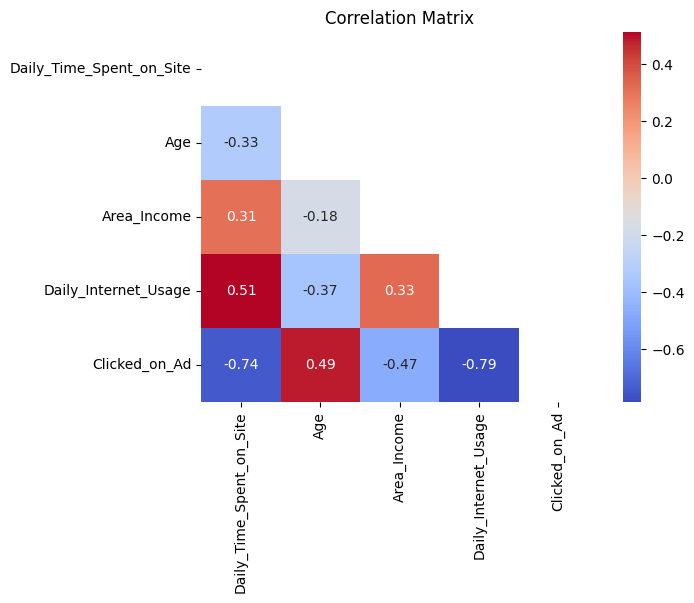

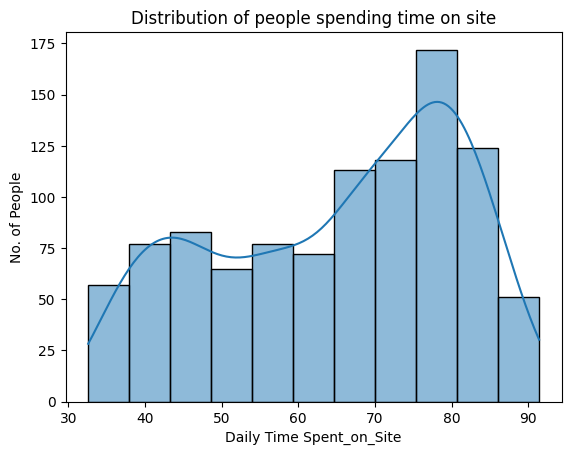

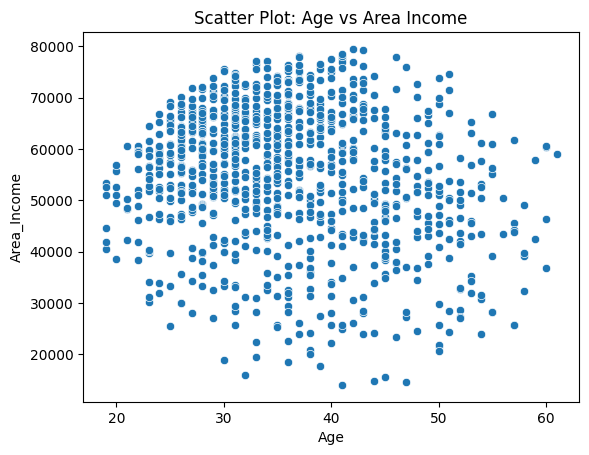

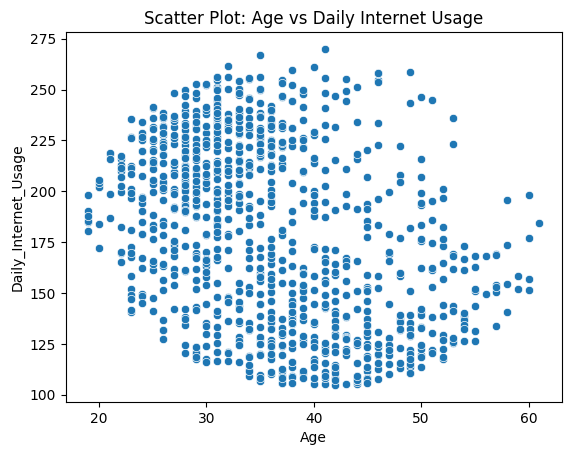

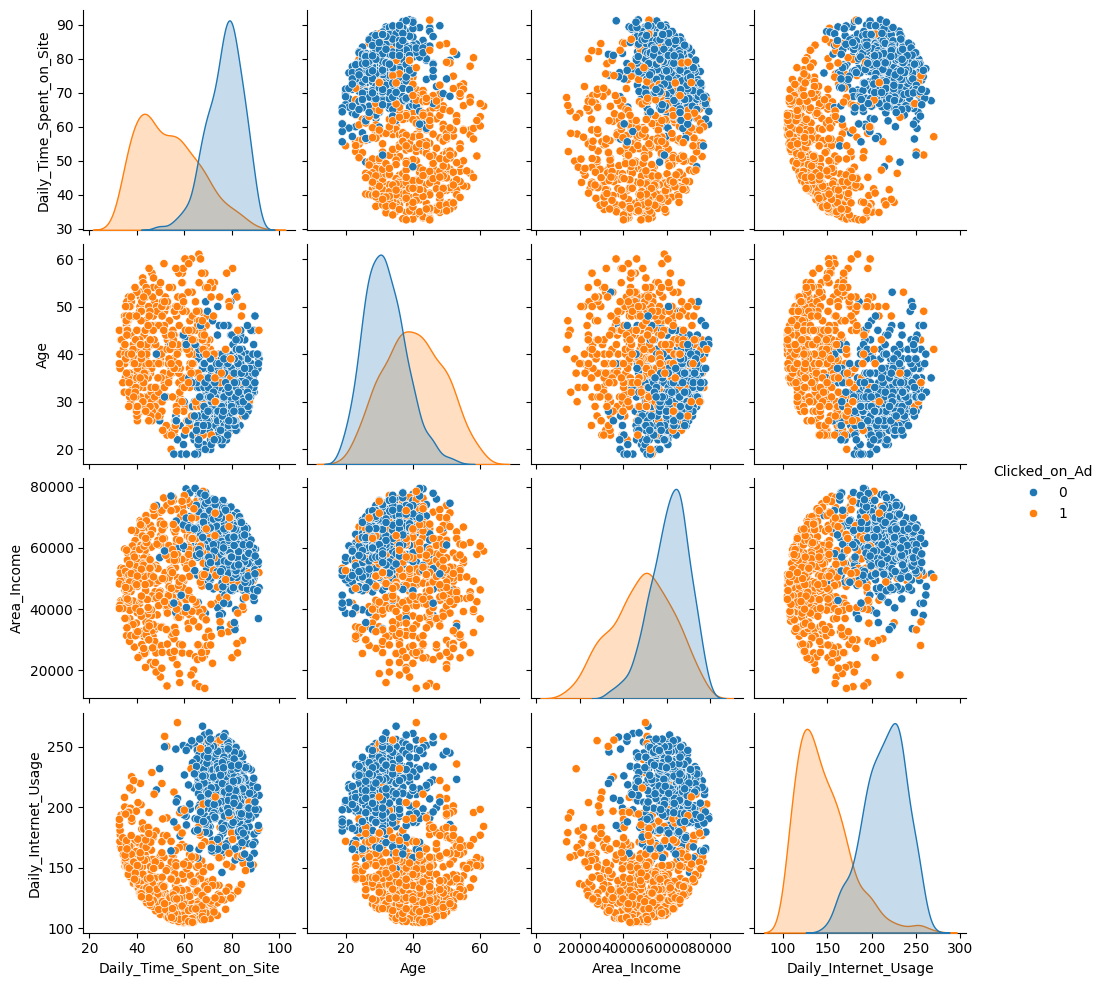

In [50]:
#Main Usage
data ='advertising_ef.csv'

model_name = 'logisticregression'
target_name1 = 'Gender'
target_name2 = 'Clicked_on_Ad'

df = pd.read_csv(data)
# raw data info
df.info()

# Clean and preprocess the data
cl_df = preprocess_data(data)

#cleaned data info
cl_df.info()

#correlation matrix
visualize_correlation_matrix(cl_df,'LR')

visualize_data(cl_df,model_name)

label_encode_categorical_column(cl_df, 'Gender')

# Save the cleaned data to a new CSV file
cl_df.to_csv('processed_data.csv', index=False)

# Target Variable - Gender

Value counts for Gender:
Gender
0    525
1    484
Name: count, dtype: int64



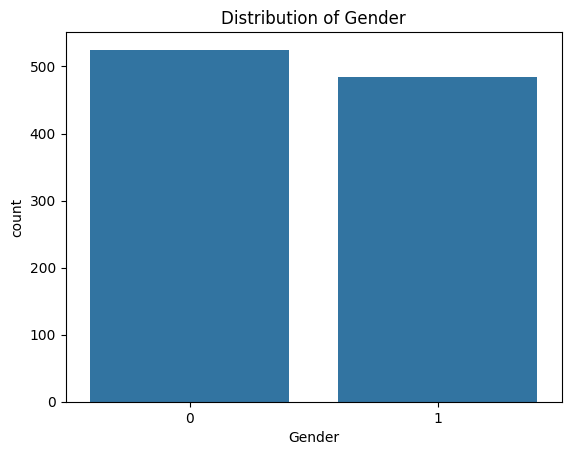

Target Variable: 0       0
1       1
2       0
3       1
4       0
       ..
1004    1
1005    1
1006    1
1007    0
1008    0
Name: Gender, Length: 1009, dtype: int64
Accuracy Score: 0.46534653465346537
Precision Score: 0.5333333333333333
Recall Score: 0.07339449541284404
F1 Score: 0.12903225806451613
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.92      0.61        93
           1       0.53      0.07      0.13       109

    accuracy                           0.47       202
   macro avg       0.50      0.50      0.37       202
weighted avg       0.50      0.47      0.35       202

Confusion Matrix:
 [[ 86   7]
 [101   8]]
Mean Accuracy Score: 0.4797619047619047
Standard Deviation of Accuracy Score: 0.09626971041224308


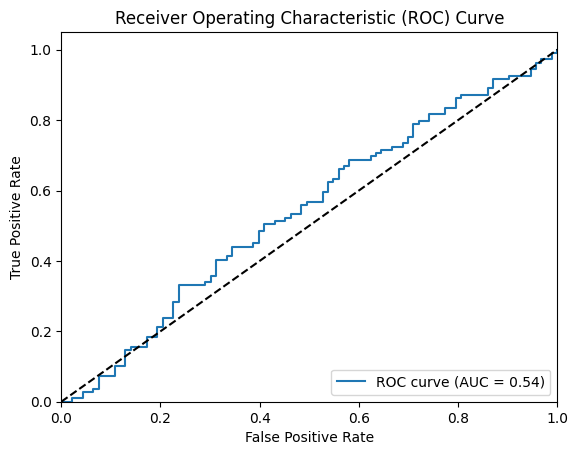

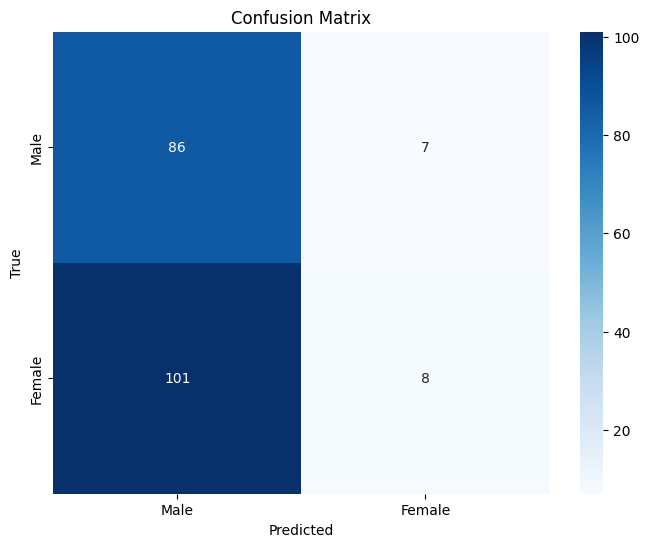

Accuracy on the testing set: 0.46534653465346537
Accuracy: 0.46534653465346537
Precision: 0.5333333333333333
Recall: 0.07339449541284404
F1-score: 0.12903225806451613
Metrics saved to logisticregression_Gender_metrics.txt
Model saved to LR_Gender.pkl


In [51]:
# For Target Variable - Gender
categorical_features = ['Gender']
analyze_categorical_features(cl_df, categorical_features,model_name, target_name1)

y = cl_df['Gender']
X = cl_df.iloc[:,[0,1,2,3]]

X_train , X_test , y_train , y_test = split_data(X , y , test_size = 0.2, random_state=42)

#label_encode_categorical_column(cl_df, 'Gender')

model1,_ = logistic_regression_model(cl_df, X, y , X_train, X_test , y_train , y_test)

y_pred = model1.predict(X_test)

# Calculate predicted probabilities
y_pred_prob = model1.predict_proba(X_test)[:, 1]


# Plot and analyze the ROC curve
plot_roc_curve(y_test, y_pred_prob, model_name,target_name1)

#Confusion Matrix
class_names = ['Male', 'Female']  # Replace with your actual class names
plot_confusion_matrix(y_test, y_pred, class_names,target_name1)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the testing set:", accuracy)

compare_metrics(model1, None, X_test, y_test)


save_metrics_to_file(model_name, target_name1,y_test, y_pred_prob, model1, model2=None)
save_model_with_pickle(model1, 'LR_Gender.pkl')

**For Gender Prediction**:

Mean Accuracy Score: 0.479761904761904
Standard Deviation of Accuracy Score: 0.09626971041224308

From this, we can say that **Standard Deviation is high** and **Accuracy is not good enough.**

# Target Variable - Click on Ads

Value counts for Clicked_on_Ad:
Clicked_on_Ad
1    506
0    503
Name: count, dtype: int64



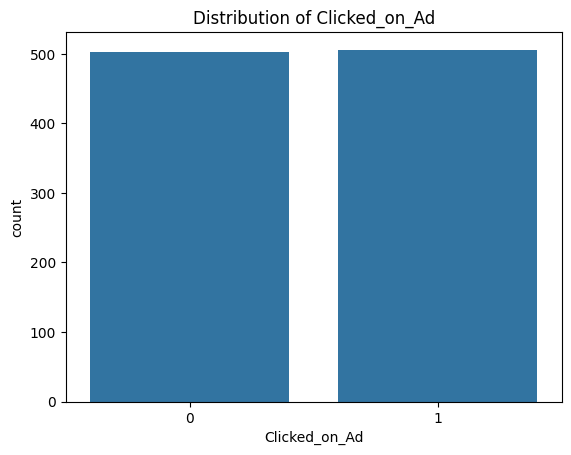

BEFORE HYPERPARAMETER TUNING
Target Variable: 0       0
1       0
2       0
3       0
4       0
       ..
1004    1
1005    1
1006    1
1007    0
1008    1
Name: Clicked_on_Ad, Length: 1009, dtype: int64
Accuracy Score: 0.9603960396039604
Precision Score: 0.9622641509433962
Recall Score: 0.9622641509433962
F1 Score: 0.9622641509433962
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        96
           1       0.96      0.96      0.96       106

    accuracy                           0.96       202
   macro avg       0.96      0.96      0.96       202
weighted avg       0.96      0.96      0.96       202

Confusion Matrix:
 [[ 92   4]
 [  4 102]]
Mean Accuracy Score: 0.9404761904761905
Standard Deviation of Accuracy Score: 0.05799953084492402
AFTER HYPERPARAMETER TUNING
Target Variable: 0       0
1       0
2       0
3       0
4       0
       ..
1004    1
1005    1
1006    1
1007    0
1008    1
Name: Clicked_on_

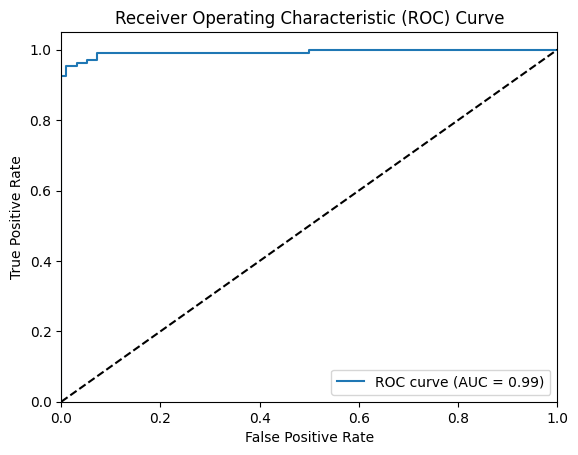

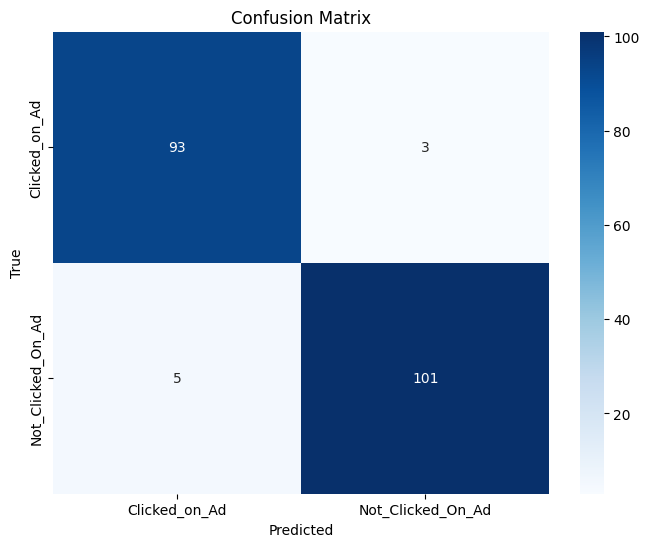

Accuracy on the testing set: 0.9603960396039604
Metrics Before Hyperparameter Tuning:
Accuracy: 0.9603960396039604
Precision: 0.9622641509433962
Recall: 0.9622641509433962
F1-score: 0.9622641509433962

Metrics After Hyperparameter Tuning:
Accuracy: 0.9603960396039604
Precision: 0.9711538461538461
Recall: 0.9528301886792453
F1-score: 0.9619047619047619
Metrics saved to logisticregression_Clicked_on_Ad_metrics.txt
Model saved to LR_Click_Ads.pkl


In [52]:
#For Target Variable - Clicked on Ads
categorical_features = ['Clicked_on_Ad']
analyze_categorical_features(cl_df, categorical_features,model_name, target_name2)

y = cl_df['Clicked_on_Ad']
X = cl_df.iloc[:,[0,1,2,3]]


X_train , X_test , y_train , y_test = split_data(X,y,test_size=0.2, random_state=42)

#Data Modeling
label_encode_categorical_column(cl_df, 'Gender')


#Before hyperparameter tuning
print("BEFORE HYPERPARAMETER TUNING")

model_before_tuning, _= logistic_regression_model(cl_df, X , y , X_train ,X_test, y_train, y_test)

y_pred = model_before_tuning.predict(X_test)
# Calculate predicted probabilities
y_pred_prob = model_before_tuning.predict_proba(X_test)[:, 1]


#After hyperparameter Tuning
print("AFTER HYPERPARAMETER TUNING")

model_after_tuning = tune_logistic_regression(cl_df,X, y,X_train , X_test, y_train, y_test)

y_pred_hp = model_after_tuning.predict(X_test)
# Calculate predicted probabilities
y_pred_prob = model_after_tuning.predict_proba(X_test)[:, 1]


plot_roc_curve(y_test, y_pred_prob, model_name,target_name2)

class_names = ['Clicked_on_Ad', 'Not_Clicked_On_Ad']  # Replace with your actual class names
plot_confusion_matrix(y_test, y_pred_hp, class_names,target_name2)

accuracy = accuracy_score(y_test, y_pred_hp)
print("Accuracy on the testing set:", accuracy)

compare_metrics(model_before_tuning, model_after_tuning, X_test, y_test)

save_metrics_to_file(model_name, target_name2, y_test, y_pred_prob, model_before_tuning, model_after_tuning)
save_model_with_pickle(model_after_tuning, 'LR_Click_Ads.pkl')